# I. Preliminaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

import folium
import requests

from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from yellowbrick.cluster import KElbowVisualizer

import sklearn.metrics as sm
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report

c:\users\alfre\documents\env\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
CLIENT_ID = 'HW2BMKCIJMFDHVHTRUGVFPB4XJL1U5EYVKOYW0BZ0FRRAX3V' # your Foursquare ID
CLIENT_SECRET = 'J2OZP1INRNJFY5TJDQDUNZDGIHCOLNUJAHUEV0ZPAXZKTUMR' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 100

In [3]:
df = pd.read_html('https://purlp.com/taguig/')[0]
Taguig_zip = df.iloc[1:]

Taguig_zip = Taguig_zip.rename(columns = Taguig_zip.iloc[0]).drop(Taguig_zip.index[0])
Taguig_zip = Taguig_zip[['Postal Codes', 'Locations']]


Taguig_zip.head()

,Postal Codes,Locations
2,1630,Bagumbayan; Pinagsama (including EP Village)
3,1636,Bay Breeze Executive Village
4,1636,"Maharlika Village, Taguig"
5,1636,"Tanyag, Taguig"
6,1631,Bicutan


In [4]:
ph_zip = pd.read_csv('C:\\Users\\alfre\\Documents\\env\\IBM_Capstone\\Coursera_Capstone\\PH.csv', sep=',', encoding='latin-1', header=0)
ph_zip.head()

,Zip Code,Neighborhood,Latitude,Longitude
0,1630,Bagumbayan; Pinagsama (including EP Village),14.517618,121.048676
1,1636,Bay Breeze Executive Village,14.512020,121.078615
2,1636,"Maharlika Village, Taguig",14.498195,121.051167
3,1636,"Tanyag, Taguig",14.476468,121.044121
4,1631,Bicutan,14.497467,121.045143


In [5]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [6]:
# Select first building (which in our case is BedokVille):
#neighborhood_name = ph_zip.loc[0, 'Neighborhood']
neighborhood_latitude = 14.505
neighborhood_longitude = 121.0509
# limit of number of venues returned by Foursquare API
LIMIT = 100 
radius = 500

In [7]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()

In [8]:
venues = results['response']['groups'][0]['items']
nearby_venues = pd.json_normalize(venues)

In [9]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

,name,categories,lat,lng
0,North Park Noodles,Chinese Restaurant,14.508299,121.050637
1,McDonald's,Fast Food Restaurant,14.505924,121.052106
2,SM Hypermarket,Market,14.508448,121.050577
3,Jollibee,Fast Food Restaurant,14.504747,121.052948
4,Puregold FTI,Supermarket,14.506034,121.052007


# II. Building Taguig Venue Data Set

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
nearby_venues

,name,categories,lat,lng
0,North Park Noodles,Chinese Restaurant,14.508299,121.050637
1,McDonald's,Fast Food Restaurant,14.505924,121.052106
2,SM Hypermarket,Market,14.508448,121.050577
3,Jollibee,Fast Food Restaurant,14.504747,121.052948
4,Puregold FTI,Supermarket,14.506034,121.052007
5,Budget Mart,Convenience Store,14.504647,121.052991
6,Plato Wraps SM Mall of Asia,Food Truck,14.508346,121.050556
7,BDO,ATM,14.508447,121.050489
8,Burger Machine,Burger Joint,14.508410,121.053372


In [12]:
taguig_venues = getNearbyVenues(names=ph_zip['Neighborhood'],
                                   latitudes=ph_zip['Latitude'],
                                   longitudes=ph_zip['Longitude']
                                  )
taguig_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bagumbayan; Pinagsama (including EP Village),14.517618,121.048676,McDonald's,14.516306,121.051504,Fast Food Restaurant
1,Bagumbayan; Pinagsama (including EP Village),14.517618,121.048676,C5 Waterfun,14.516760,121.051396,Sculpture Garden
2,Bagumbayan; Pinagsama (including EP Village),14.517618,121.048676,Heritage Park Jogging Oval,14.519163,121.049195,Park
3,Bagumbayan; Pinagsama (including EP Village),14.517618,121.048676,Cebuana Lhuiller,14.516615,121.051414,Jewelry Store
4,Bagumbayan; Pinagsama (including EP Village),14.517618,121.048676,Philippine Veterans Museum,14.514209,121.047617,History Museum


In [13]:
taguig_venues = taguig_venues[(taguig_venues['Venue Category']!='Intersection')
                             &(taguig_venues['Venue Category']!='Train Station')
                             &(taguig_venues['Venue Category']!='Bus Station')
                             &(taguig_venues['Venue Category']!='Toll Plaza')
                             &(taguig_venues['Venue Category']!='Hotel')
                             &(taguig_venues['Venue Category']!='Neighborhood')
                             &(taguig_venues['Venue Category']!='Construction & Landscaping')
                             &(taguig_venues['Venue Category']!='Government Building')
                             &(taguig_venues['Venue']!='C5 Waterfun')
                             &(taguig_venues['Venue']!='Cebuana Lhuiller')
                             &(taguig_venues['Venue']!='SLEX C5 Toll')]

In [14]:
venues_map = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=12.5)
# add a red circle marker to represent the Taguig Neighborhoods

for i in ph_zip.index:
    folium.CircleMarker(
        [ph_zip['Latitude'][i], ph_zip['Longitude'][i]],
        radius=50,
        color='red',
        popup=ph_zip['Neighborhood'][i],
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.1
    ).add_to(venues_map)



# add all venues as blue circle markers
for j in taguig_venues.index:
    folium.Marker(
        [taguig_venues['Venue Latitude'][j], taguig_venues['Venue Longitude'][j]],
        radius=5,
        color='blue',
        popup=taguig_venues['Venue'][j],
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

venues_map

In [15]:
print(taguig_venues['Venue Category'].unique().shape)


(100,)


In [16]:
taguig_venues['Flag Food'] = np.where(taguig_venues['Venue Category'].str.contains(pat='restaurant',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='food',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='Snack',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='Coffee',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='bagel',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='cafeteria',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='bakery',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='bbq',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='ice cream',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='dessert',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='pizza',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='burger',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='tea',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='Wings Joint',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='fried chicken Joint',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='diner',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='donut',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='Café',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='Sandwich',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='cupcake',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='breakfast',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='deli',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='bistro',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='noodle',case=False)
                                      ,1,0)

taguig_venues['Flag Recreation'] = np.where(taguig_venues['Venue Category'].str.contains(pat='park',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='playground',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='recreation',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='plaza',case=False)
                                      ,1,0)

taguig_venues['Flag Fitness'] = np.where(taguig_venues['Venue Category'].str.contains(pat='gym',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='basketball',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='soccer',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='golf',case=False) 
                                      |taguig_venues['Venue Category'].str.contains(pat='Athletics & Sports',case=False) 
                                      ,1,0)

taguig_venues['Flag Market'] = np.where(taguig_venues['Venue Category'].str.contains(pat='market',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='grocery',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='convenience store',case=False)
                                      ,1,0)

taguig_venues['Flag Utility'] = np.where(taguig_venues['Venue Category'].str.contains(pat='pharmacy',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='auto',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='motorcycle',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='health',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='beauty',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='Sporting Goods',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='electronics',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='laundromat',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='veterinarian',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='mobile phone',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='department store',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='clothing',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='shoe',case=False)
                                      ,1,0)

taguig_venues['Flag Leisure'] = np.where(taguig_venues['Venue Category'].str.contains(pat='museum',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='nightclub',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='mall',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='bar',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='bookstore',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='spa',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='multiplex',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='bowling alley',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='casino',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='pool',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='gift',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='movie',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='jewelry',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='theater',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='cosmetics',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='gaming',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='board',case=False)
                                      |taguig_venues['Venue Category'].str.contains(pat='lounge',case=False)
                                      ,1,0)
#Checks Redandancy and nonflagging

Food_test = taguig_venues['Flag Food'].sum()
Recreation_test = taguig_venues['Flag Recreation'].sum()
Fitness_test = taguig_venues['Flag Fitness'].sum()
Market_test = taguig_venues['Flag Market'].sum()
Utility_test = taguig_venues['Flag Utility'].sum()
Leisure_test = taguig_venues['Flag Leisure'].sum()



#Removes Transport and other venue categories lacking foursquare Data
tauig_venues = taguig_venues[(taguig_venues['Flag Food']==1)
             |(taguig_venues['Flag Recreation']==1)
             |(taguig_venues['Flag Fitness']==1)
             |(taguig_venues['Flag Market']==1)
             |(taguig_venues['Flag Utility']==1)
             |(taguig_venues['Flag Leisure']==1)]

Sum_Test = Food_test + Recreation_test + Fitness_test + Market_test + Utility_test + Leisure_test
print('Test if the number of Venue Category',taguig_venues.shape[0],'is equal to',Sum_Test,'the number of Categorized Amenities')

taguig_venues.reset_index(drop=True, inplace=True)

Test if the number of Venue Category 368 is equal to 368 the number of Categorized Amenities


In [17]:
taguig_venues.head(20)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Flag Food,Flag Recreation,Flag Fitness,Flag Market,Flag Utility,Flag Leisure
0,Bagumbayan; Pinagsama (including EP Village),14.517618,121.048676,McDonald's,14.516306,121.051504,Fast Food Restaurant,1,0,0,0,0,0
1,Bagumbayan; Pinagsama (including EP Village),14.517618,121.048676,Heritage Park Jogging Oval,14.519163,121.049195,Park,0,1,0,0,0,0
2,Bagumbayan; Pinagsama (including EP Village),14.517618,121.048676,Philippine Veterans Museum,14.514209,121.047617,History Museum,0,0,0,0,0,1
3,Bagumbayan; Pinagsama (including EP Village),14.517618,121.048676,HBC,14.515108,121.052174,Cosmetics Shop,0,0,0,0,0,1
4,Bay Breeze Executive Village,14.512020,121.078615,NAIA Canteen,14.509831,121.080218,Cafeteria,1,0,0,0,0,0
5,Bay Breeze Executive Village,14.512020,121.078615,Siomai House,14.514723,121.081629,Food Truck,1,0,0,0,0,0
6,Bay Breeze Executive Village,14.512020,121.078615,Phines Bakery,14.516211,121.077801,Bakery,1,0,0,0,0,0
7,Bay Breeze Executive Village,14.512020,121.078615,All Day Supermarket,14.512756,121.074039,Market,0,0,0,1,0,0
8,"Maharlika Village, Taguig",14.498195,121.051167,Ayala Malls Arca South,14.496085,121.047928,Shopping Mall,0,0,0,0,0,1
9,"Maharlika Village, Taguig",14.498195,121.051167,McDonald's,14.502004,121.051440,Fast Food Restaurant,1,0,0,0,0,0


In [31]:
#Uncomment the succeeding lines to Check What Venue Category an amenity is flagged as


#taguig_venues[taguig_venues['Flag Food'] == 1]['Venue Category']
#taguig_venues[taguig_venues['Flag Recreation'] == 1]['Venue Category']
#taguig_venues[taguig_venues['Flag Fitness'] == 1]['Venue Category']
#taguig_venues[taguig_venues['Flag Market'] == 1]['Venue Category']
#taguig_venues[taguig_venues['Flag Utility'] == 1]['Venue Category']
#taguig_venues[taguig_venues['Flag Leisure'] == 1]['Venue Category']

print('Number of Food Amennity',taguig_venues[taguig_venues['Flag Food'] == 1]['Venue Category'].count())
print('Number of Recreation Amennity',taguig_venues[taguig_venues['Flag Recreation'] == 1]['Venue Category'].count())
print('Number of Fitness Amennity',taguig_venues[taguig_venues['Flag Fitness'] == 1]['Venue Category'].count())
print('Number of Market Amennity',taguig_venues[taguig_venues['Flag Market'] == 1]['Venue Category'].count())
print('Number of Utility Amennity',taguig_venues[taguig_venues['Flag Utility'] == 1]['Venue Category'].count())
print('Number of Leisure Amennity',taguig_venues[taguig_venues['Flag Leisure'] == 1]['Venue Category'].count())

Number of Food Amennity 223
Number of Recreation Amennity 10
Number of Fitness Amennity 21
Number of Market Amennity 42
Number of Utility Amennity 23
Number of Leisure Amennity 49


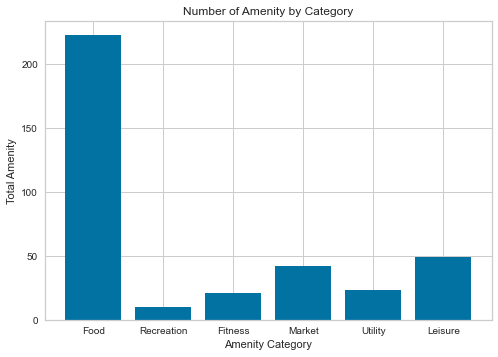

In [26]:
count_amenities = [Food_test, Recreation_test, Fitness_test ,Market_test, Utility_test, Leisure_test]
amenities = ['Food', 'Recreation', 'Fitness', 'Market', 'Utility', 'Leisure']

x_pos = [i for i, _ in enumerate(amenities)]

plt.bar(x_pos, count_amenities)
plt.xlabel("Amenity Category")
plt.ylabel("Total Amenity")
plt.title("Number of Amenity by Category")

plt.xticks(x_pos, amenities)

plt.show()

In [20]:
X = taguig_venues[['Venue Latitude','Venue Longitude']]
#Y = taguig_venues['Venue Longitude']

# III. Setting up KMeans

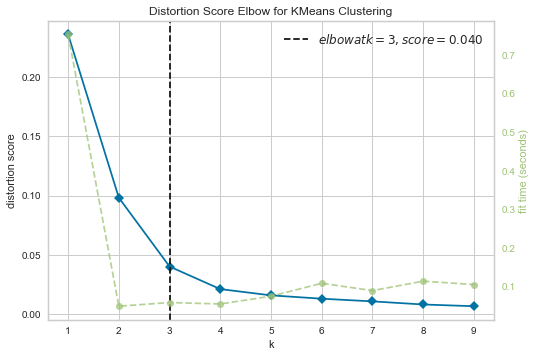

In [21]:
visualizer = KElbowVisualizer(KMeans(), k=(1,10))
visualizer.fit(X)
visualizer.show()

In [22]:
clustering = KMeans(n_clusters=3)
clustering.fit_predict(X)
clustering.cluster_centers_
taguig_venues['Cluster'] = clustering.labels_

In [23]:
cluster_map = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=12.5)
# add a red circle marker to represent the Taguig Neighborhoods

centers = clustering.cluster_centers_

for i in range(3):
    folium.CircleMarker(
        [centers[i][0],centers[i][1]],
        radius=120,
        color='red',
        fill = True,
        fill_color = 'red',
        fill_opacity = 0.1
    ).add_to(cluster_map)


cluster_map

In [24]:
cluster_venue_map = folium.Map(location=[neighborhood_latitude, neighborhood_longitude], zoom_start=12.5)

for j in taguig_venues.index:
    if taguig_venues['Cluster'][j] == 0:
        folium.Marker(
            [taguig_venues['Venue Latitude'][j], taguig_venues['Venue Longitude'][j]],
            radius=5,
            color='blue',
            popup=taguig_venues['Venue'][j],
            fill = True,
            fill_color='blue',
            icon=folium.Icon(color='blue'),
            fill_opacity=0.6
        ).add_to(cluster_venue_map)
    elif taguig_venues['Cluster'][j] == 1:
        folium.Marker(
            [taguig_venues['Venue Latitude'][j], taguig_venues['Venue Longitude'][j]],
            radius=5,
            color='green',
            popup=taguig_venues['Venue'][j],
            fill = True,
            fill_color='green',
            icon=folium.Icon(color='green'),
            fill_opacity=0.6
        ).add_to(cluster_venue_map)
    elif taguig_venues['Cluster'][j] == 2:
        folium.Marker(
            [taguig_venues['Venue Latitude'][j], taguig_venues['Venue Longitude'][j]],
            radius=5,
            color='purple',
            popup=taguig_venues['Venue'][j],
            fill = True,
            fill_color='purple',
            icon=folium.Icon(color='purple'),
            fill_opacity=0.6
        ).add_to(cluster_venue_map)


cluster_venue_map

In [37]:
print('Number Food Amenities per Cluster:')
print('cluster1:',taguig_venues.loc[taguig_venues['Cluster'] == 0, 'Flag Food'].sum())
print('cluster2:',taguig_venues.loc[taguig_venues['Cluster'] == 1, 'Flag Food'].sum())
print('cluster3:',taguig_venues.loc[taguig_venues['Cluster'] == 2, 'Flag Food'].sum())

print('Number Recreation Amenities per Cluster:')
print('cluster1:',taguig_venues.loc[taguig_venues['Cluster'] == 0, 'Flag Recreation'].sum())
print('cluster2:',taguig_venues.loc[taguig_venues['Cluster'] == 1, 'Flag Recreation'].sum())
print('cluster3:',taguig_venues.loc[taguig_venues['Cluster'] == 2, 'Flag Recreation'].sum())

print('Number Fitness Amenities per Cluster:')
print('cluster1:',taguig_venues.loc[taguig_venues['Cluster'] == 0, 'Flag Fitness'].sum())
print('cluster2:',taguig_venues.loc[taguig_venues['Cluster'] == 1, 'Flag Fitness'].sum())
print('cluster3:',taguig_venues.loc[taguig_venues['Cluster'] == 2, 'Flag Fitness'].sum())

print('Number Market Amenities per Cluster:')
print('cluster1:',taguig_venues.loc[taguig_venues['Cluster'] == 0, 'Flag Market'].sum())
print('cluster2:',taguig_venues.loc[taguig_venues['Cluster'] == 1, 'Flag Market'].sum())
print('cluster3:',taguig_venues.loc[taguig_venues['Cluster'] == 2, 'Flag Market'].sum())

print('Number Utility Amenities per Cluster:')
print('cluster1:',taguig_venues.loc[taguig_venues['Cluster'] == 0, 'Flag Utility'].sum())
print('cluster2:',taguig_venues.loc[taguig_venues['Cluster'] == 1, 'Flag Utility'].sum())
print('cluster3:',taguig_venues.loc[taguig_venues['Cluster'] == 2, 'Flag Utility'].sum())

print('Number Leisure Amenities per Cluster:')
print('cluster1:',taguig_venues.loc[taguig_venues['Cluster'] == 0, 'Flag Leisure'].sum())
print('cluster2:',taguig_venues.loc[taguig_venues['Cluster'] == 1, 'Flag Leisure'].sum())
print('cluster3:',taguig_venues.loc[taguig_venues['Cluster'] == 2, 'Flag Leisure'].sum())

Number Food Amenities per Cluster:
cluster1: 24
cluster2: 147
cluster3: 52
Number Recreation Amenities per Cluster:
cluster1: 0
cluster2: 7
cluster3: 3
Number Fitness Amenities per Cluster:
cluster1: 2
cluster2: 13
cluster3: 6
Number Market Amenities per Cluster:
cluster1: 2
cluster2: 31
cluster3: 9
Number Utility Amenities per Cluster:
cluster1: 3
cluster2: 13
cluster3: 7
Number Leisure Amenities per Cluster:
cluster1: 22
cluster2: 20
cluster3: 7


In [52]:
print('The Barangays in cluster 1 are: ',taguig_venues.loc[taguig_venues['Cluster'] == 0, 'Neighborhood'].count())

The Barangays in cluster 1 are:  53


In [53]:
print('The Barangays in cluster 2 are: ',taguig_venues.loc[taguig_venues['Cluster'] == 1, 'Neighborhood'].count())

The Barangays in cluster 2 are:  231


In [54]:

print('The Barangays in cluster 3 are: ',taguig_venues.loc[taguig_venues['Cluster'] == 2, 'Neighborhood'].count())

The Barangays in cluster 3 are:  84
